In [1]:
# import all the libraries
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.feature_importance_plot import feature_importance_plot
from src.learning_curve_plot import learning_curve_plot
from src.identify_and_handle_missing_data import identify_missing_data, handle_categorical_missing_data, handle_numerical_missing_data
from src.helpers import identify_number_categories, one_hot, identify_highly_correlated_features


In [2]:
# import the housing data from 

housing = fetch_openml(name="house_prices", as_frame=True)  

housing_df = pd.DataFrame(housing['data'], columns=housing['feature_names'])
housing_df['target'] = housing['target']
housing_df.drop(['Id'], inplace = True, axis = 1)



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,target
0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0
1,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,...,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0
2,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,Inside,...,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal,223500.0
3,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,Corner,...,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,FR2,...,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal,250000.0


In [56]:
pd.set_option('display.max_columns', None)

housing_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,target
0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0
1,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0
2,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal,223500.0
3,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal,250000.0


In [3]:
# check the shape of the data

housing_df.shape

# that's a lot of columns!

(1460, 80)

In [4]:
housing_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,target
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
# check for duplicated data

housing_df[housing_df.duplicated()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,target


/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


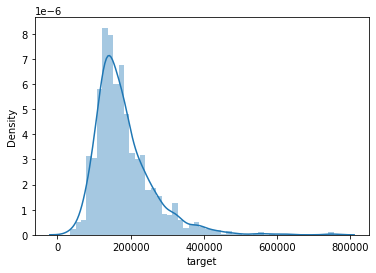

In [6]:
# check the distribution of the target

sns.distplot(housing_df.target);

# question: do you see any skew in the data?

In [7]:
housing_df.target.describe()

# some slight positive skew - this can be identified with the mode less than the median less than the mean

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: target, dtype: float64

In [8]:
print("mode of the housing_df", list(housing_df.target.mode()))

mode of the housing_df [140000.0]


/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


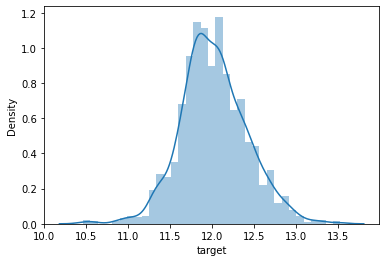

In [9]:
# what would the distribution look like if we transformed the target variable

sns.distplot(np.log(housing_df.target));

# what does the distribution look like now?

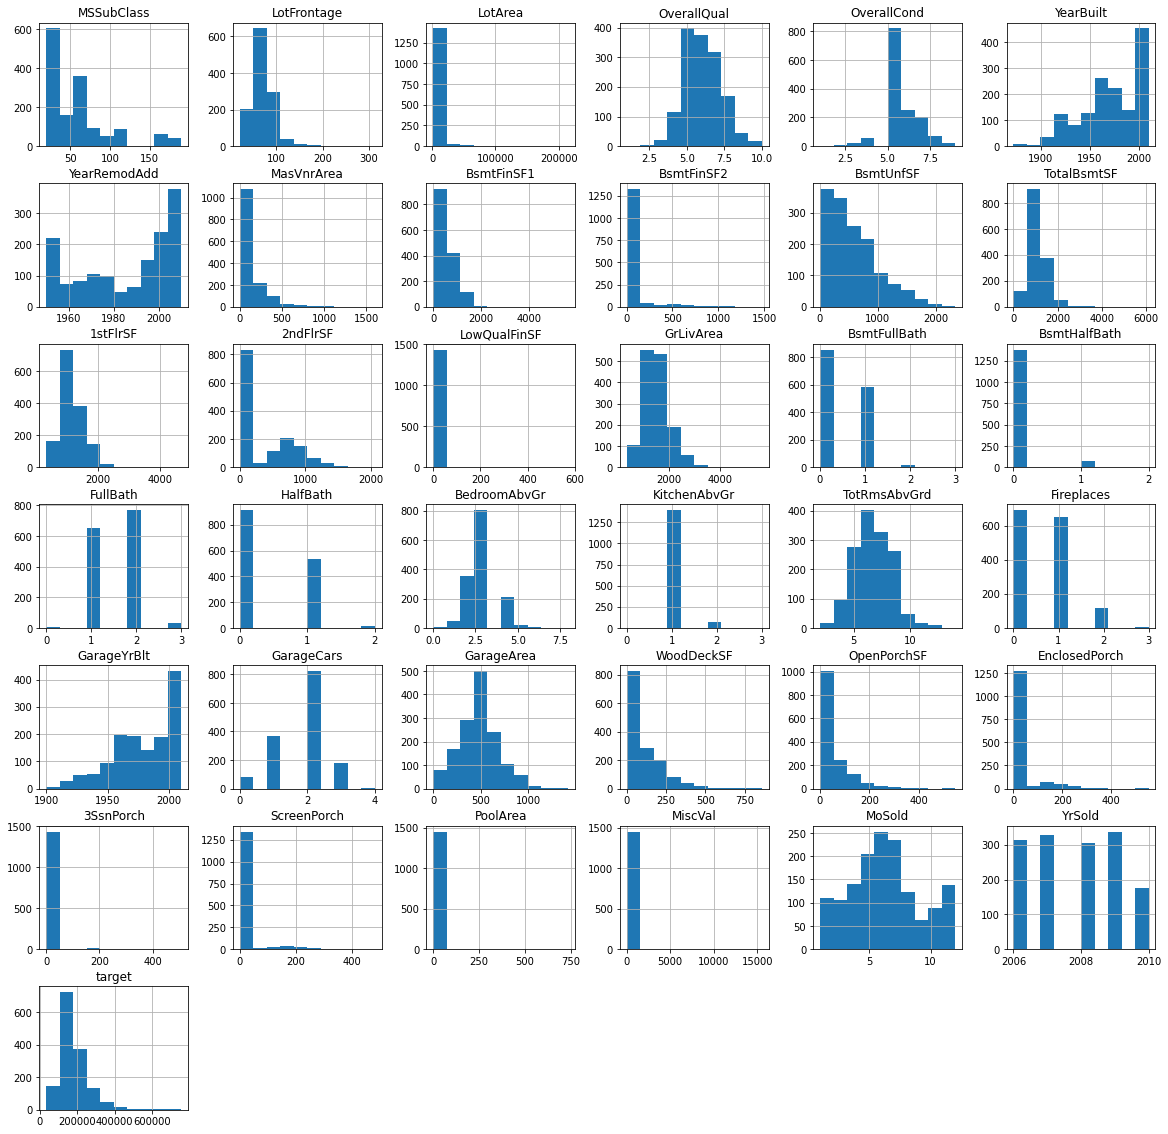

In [10]:
# what about the other numerical variables

plt.rcParams["figure.figsize"] = (20,20)

housing_df.hist();

# because of the amount of skewed data, please use tree based models only

In [11]:
# check the info of the data

housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   float64
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   float64
 17  OverallCond    1460 non-null   float64
 18  YearBuil

In [12]:
# identify how many categorical columns of data we have i.e. variables with data type object

categorical_cols = list(housing_df.select_dtypes(['object']).columns)
print("number of categorical columns:", len(categorical_cols))

number of categorical columns: 43


In [13]:
# check how many categories each categorical variable has

cat_df = identify_number_categories(housing_df)
cat_df

,categorical_feature,number_categories
8,Neighborhood,25
16,Exterior2nd,16
15,Exterior1st,15
41,SaleType,9
9,Condition1,9
10,Condition2,8
12,HouseStyle,8
14,RoofMatl,8
25,BsmtFinType2,7
31,Functional,7


In [14]:
# Because of the size of the data, drop categorical features wuth more than 5 categories

threshold = 5

features_to_drop = list(cat_df[cat_df.number_categories > threshold].categorical_feature)
print("number of features to drop:", len(features_to_drop))

number of features to drop: 20


In [15]:
features_to_drop

['Neighborhood',
 'Exterior2nd',
 'Exterior1st',
 'SaleType',
 'Condition1',
 'Condition2',
 'HouseStyle',
 'RoofMatl',
 'BsmtFinType2',
 'Functional',
 'GarageType',
 'BsmtFinType1',
 'Heating',
 'Foundation',
 'Electrical',
 'SaleCondition',
 'RoofStyle',
 'GarageQual',
 'GarageCond',
 'FireplaceQu']

In [16]:
# drop the features

housing_df_reduced = housing_df.drop(features_to_drop, axis = 1)

# check shape of the reduce dataset
housing_df_reduced.shape

(1460, 60)

In [17]:
# before doing any encoding, lets identify missing data

missing_value_df = identify_missing_data(housing_df_reduced)
missing_value_df

,feature,percent_missing,data_type
0,PoolQC,99.52,object
1,MiscFeature,96.30,object
2,Alley,93.77,object
3,Fence,80.75,object
4,LotFrontage,17.74,float64
5,GarageFinish,5.55,object
6,GarageYrBlt,5.55,float64
7,BsmtExposure,2.60,object
8,BsmtQual,2.53,object
9,BsmtCond,2.53,object


In [18]:
# drop features which have more than 40% missing values
# identify features which have more than 40% missing data

threshold = 40

cols_to_drop = list(missing_value_df[missing_value_df.percent_missing > threshold].feature)
print("number of columns to drop:", len(cols_to_drop))
print(cols_to_drop)

number of columns to drop: 4
['PoolQC', 'MiscFeature', 'Alley', 'Fence']


In [19]:
# drop the features 

housing_df_reduced.drop(cols_to_drop, axis = 1, inplace = True)

# check the size of the data
housing_df_reduced.shape

(1460, 56)

In [20]:
missing_value_df = identify_missing_data(housing_df_reduced)
missing_value_df[missing_value_df.percent_missing > 0] # only look at features where percent_missing greater than 0

,feature,percent_missing,data_type
0,LotFrontage,17.74,float64
1,GarageYrBlt,5.55,float64
2,GarageFinish,5.55,object
3,BsmtExposure,2.60,object
4,BsmtCond,2.53,object
5,BsmtQual,2.53,object
6,MasVnrType,0.55,object
7,MasVnrArea,0.55,float64


In [21]:
# replace all categorical (data type object) missing values with Unknown

handle_categorical_missing_data(housing_df_reduced)

number of categorical cols with missing data: 5
replacing missing values for: GarageFinish
replacing missing values for: BsmtExposure
replacing missing values for: BsmtCond
replacing missing values for: BsmtQual
replacing missing values for: MasVnrType


In [22]:
# replace all numerical missing (data type int, float or bool) values with 0

handle_numerical_missing_data(housing_df_reduced, fill_na_value=0)


number of numerical cols with missing data: 3
replacing missing values for LotFrontage
replacing missing values for GarageYrBlt
replacing missing values for MasVnrArea


In [24]:
# check do we have any missing data left

missing_value_df = identify_missing_data(housing_df_reduced)
missing_value_df

,feature,percent_missing,data_type
0,MSSubClass,0.0,float64
1,MSZoning,0.0,object
2,LowQualFinSF,0.0,float64
3,GrLivArea,0.0,float64
4,BsmtFullBath,0.0,float64
5,BsmtHalfBath,0.0,float64
6,FullBath,0.0,float64
7,HalfBath,0.0,float64
8,BedroomAbvGr,0.0,float64
9,KitchenAbvGr,0.0,float64


In [25]:
# encode all the categorical data

categorical_columns = list(housing_df_reduced.select_dtypes(['object']).columns) # identify all the categorical columns

housing_df_reduced_w_encoding = one_hot(housing_df_reduced, categorical_columns)

# shape of the new dataframe
housing_df_reduced_w_encoding.shape

(1460, 114)

In [26]:
# check the info - do we have any categorical data left?
# we should only have floats and uint. If this is not the case, stop and move on.

housing_df_reduced_w_encoding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 114 entries, MSSubClass to PavedDrive_Y
dtypes: float64(37), uint8(77)
memory usage: 531.9 KB


In [ ]:
# identify highly correlated features

# corr_df = identify_highly_correlated_features(housing_df_reduced_w_encoding, correlation_threshold = 0.8)
# corr_df

In [ ]:
# drop all features in the drop_feature column
# cols_to_drop = np.unique(corr_df.drop_feature)
# print("number of columns to drop:", len(cols_to_drop))


In [ ]:
# drop the correlated features

# housing_df_final = housing_df_reduced_w_encoding.drop(columns=corr_df.drop_feature)

# check shape of new dataframe
# housing_df_final.shape

In [27]:
# define the target and features

target = housing_df_reduced_w_encoding["target"]
features = housing_df_reduced_w_encoding.drop(["target"], axis = 1)

In [28]:
target.shape

(1460,)

In [29]:
features.shape

(1460, 113)

In [30]:
# split the data into train and test set
# because the dataset is imbalanced we can use stratify

X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target,
                                                test_size = 0.3, 
                                                random_state = 8)


In [31]:
# print the shape of the training data

print("Training Data")
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)

Training Data
Shape of X_train (1022, 113)
Shape of y_train (1022,)


In [32]:
# print the shape of the test data 

print("Test Data")
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)

Test Data
Shape of X_test (438, 113)
Shape of y_test (438,)


In [33]:
# Build a Decision Tree Model

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)


In [34]:
print("first five predicted values:", y_pred_dt[0:5])
print("first five actual values:", list(y_test[0:5]))

first five predicted values: [231500. 119500. 134900. 176000. 187000.]
first five actual values: [181000.0, 124500.0, 114500.0, 155000.0, 187500.0]


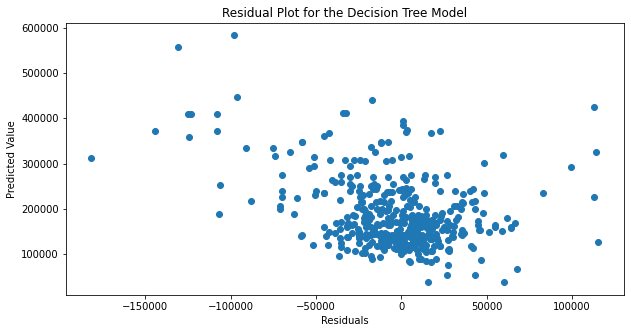

In [35]:
# residual plot

plt.rcParams["figure.figsize"] = (10,5)

residuals = y_test - y_pred_dt

plt.scatter(residuals, y_pred_dt)
plt.title("Residual Plot for the Decision Tree Model")
plt.xlabel("Residuals")
plt.ylabel("Predicted Value")
plt.show();

# we want them the points to be centred around 0

In [36]:
# the evaluation metrics for the model on the test set
r2 = r2_score(y_test, y_pred_dt)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_test, y_pred_dt)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_test, y_pred_dt)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_dt)
print("Mean Squared Error:", round(mse))

R2: 0.76
Explained Variance: 0.76
Mean Absolute Error: 24424
Mean Squared Error: 1262339464


In [37]:
# the evaluation metrics for the model on the training set

y_pred_train_dt = dt.predict(X_train)

r2 = r2_score(y_train, y_pred_train_dt)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_train, y_pred_train_dt)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_train, y_pred_train_dt)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_dt)
print("Mean Squared Error:", round(mse))

# seeing low error rates on the training set, in this case no error rate - signs of overfitting

R2: 1.0
Explained Variance: 1.0
Mean Absolute Error: 0
Mean Squared Error: 0


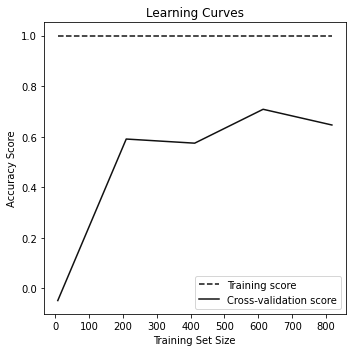

In [38]:
learning_curve_plot(dt, X_train, y_train, scoring = 'r2')

# what can we conclude about the decisiom tree model based on the learning curves?

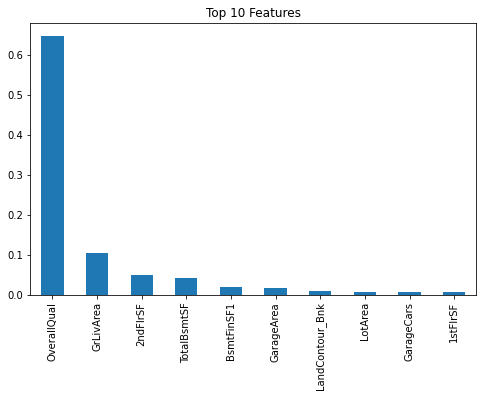

In [39]:
# feature importance plot

feature_importance_plot(dt, X_train, 10)

In [40]:
# what are the top 20 lowest features

feat_importances = pd.Series(dt.feature_importances_,
                                 index = X_train.columns)
feat_importance_df = pd.DataFrame(feat_importances).sort_values(by = 0).reset_index().rename(columns = {'index': 'feature',
                                                                                        0: 'score'})
feat_importance_df.head(20)

# we can see 18 features with no feature importance at all
# next iteration, we remove features with no importance and see if this improves
# we could also consider a threshold

,feature,score
0,ExterCond_Ex,0.0
1,Utilities_NoSeWa,0.0
2,MiscVal,0.0
3,PoolArea,0.0
4,PavedDrive_P,0.0
5,LandSlope_Gtl,0.0
6,LandSlope_Sev,0.0
7,BldgType_Duplex,0.0
8,LandContour_Low,0.0
9,Street_Grvl,0.0


In [41]:
# Build a Random Forest Model

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [42]:
print("first five predicted values:", y_pred_rf[0:5])
print("first five actual values:", list(y_test[0:5]))

first five predicted values: [186361.27 129998.   126083.3  145196.5  200345.97]
first five actual values: [181000.0, 124500.0, 114500.0, 155000.0, 187500.0]


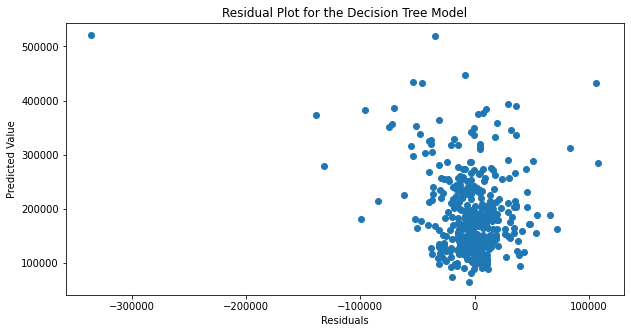

In [43]:
# residual plot

plt.rcParams["figure.figsize"] = (10,5)

residuals = y_test - y_pred_rf

plt.scatter(residuals, y_pred_rf)
plt.title("Residual Plot for the Decision Tree Model")
plt.xlabel("Residuals")
plt.ylabel("Predicted Value")
plt.show();

# we want them the points to be centred around 0

In [44]:
# the evaluation metrics for the model on the test set
r2 = r2_score(y_test, y_pred_rf)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_test, y_pred_rf)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_test, y_pred_rf)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error:", round(mse))

R2: 0.83
Explained Variance: 0.84
Mean Absolute Error: 17216
Mean Squared Error: 885127902


In [45]:
# the evaluation metrics for the model on the training set

y_pred_train_rf = rf.predict(X_train)

r2 = r2_score(y_train, y_pred_train_rf)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_train, y_pred_train_rf)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_train, y_pred_train_rf)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_rf)
print("Mean Squared Error:", round(mse))

# seeing low error rates on the training set, in this case no error rate - signs of overfitting

R2: 0.98
Explained Variance: 0.98
Mean Absolute Error: 6643
Mean Squared Error: 133050166


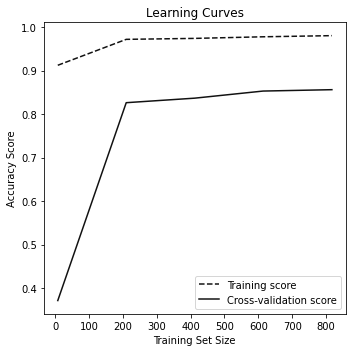

In [46]:
learning_curve_plot(rf, X_train, y_train, scoring = 'r2')

# what can we conclude about the random forest model based on the learning curves? less overfitting

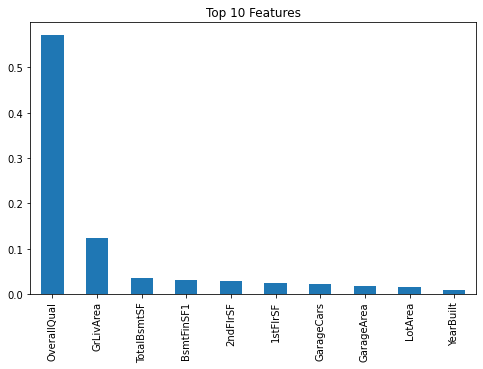

In [47]:
feature_importance_plot(rf, X_train, n = 10)

In [48]:
# Build a XGBoost

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


In [49]:
print("first five predicted values:", y_pred_xgb[0:5])
print("first five actual values:", list(y_test[0:5]))

first five predicted values: [206456.3  131687.5  122938.02 139793.61 216310.06]
first five actual values: [181000.0, 124500.0, 114500.0, 155000.0, 187500.0]


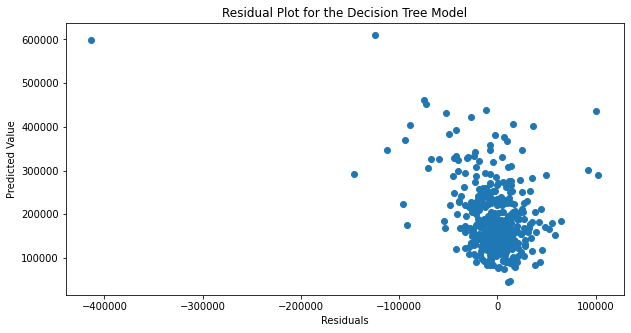

In [50]:
# residual plot

plt.rcParams["figure.figsize"] = (10,5)

residuals = y_test - y_pred_xgb

plt.scatter(residuals, y_pred_xgb)
plt.title("Residual Plot for the Decision Tree Model")
plt.xlabel("Residuals")
plt.ylabel("Predicted Value")
plt.show();

# we want them the points to be centred around 0

In [51]:
# the evaluation metrics for the model on the test set
r2 = r2_score(y_test, y_pred_xgb)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_test, y_pred_xgb)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_test, y_pred_xgb)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_xgb)
print("Mean Squared Error:", round(mse))

R2: 0.8
Explained Variance: 0.8
Mean Absolute Error: 18371
Mean Squared Error: 1059123566


In [52]:
# the evaluation metrics for the model on the training set

y_pred_train_xgb = xgb.predict(X_train)

r2 = r2_score(y_train, y_pred_train_xgb)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_train, y_pred_train_xgb)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_train, y_pred_train_xgb)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_xgb)
print("Mean Squared Error:", round(mse))

# seeing low error rates on the training set, in this case no error rate - signs of overfitting

R2: 1.0
Explained Variance: 1.0
Mean Absolute Error: 748
Mean Squared Error: 1102143


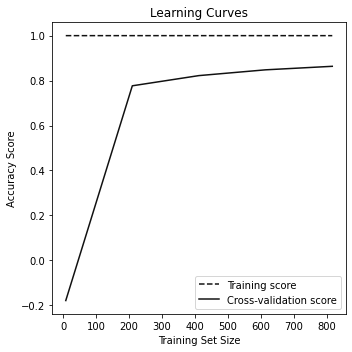

In [53]:
learning_curve_plot(xgb, X_train, y_train, scoring = 'r2')

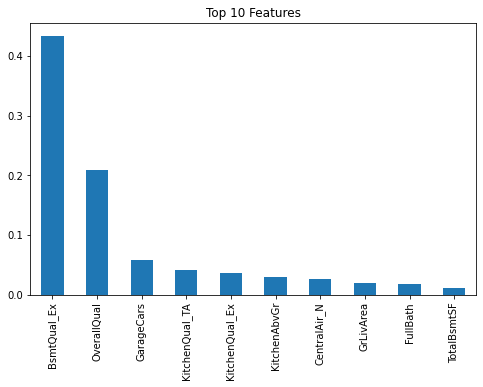

In [54]:
feature_importance_plot(xgb, X_train, n = 10)

In [ ]:
# Next time, how we can reduce the overfitting

# signs of overfitting
# remove redundant features
# feature selection e.g. removing correlated features,
# hyperparameter tuning
# try a linear regression model
# add more data -- this is not possible